<h1><center>Predikcia podania výpovede zamestnancov </center></h1>
    
<h2><center> Semestrálna práca 4IZ566 </center></h2>
    
<h3><center> Samuel Karabinoš & Filip Stárek </center></h3>

#### Cieľ
Výsledkom semestrálnej práce by malo byť nájdenie vzťahov, ktoré pomôžu pochopiť, aké skupiny zamestnancov dávajú častejšie výpoveď. 
#### Cieľová premenná
Attrition (binárna premenná - zamestnanec odišiel v predchádzajúcom roku alebo nie) 
#### Dáta
https://www.kaggle.com/traceyskagglist/hr-analytics-case-study-copy-for-class?fbclid=IwAR0EzeeOi2T8ewHHT-D_hPG7reGH9NAWW5ETlo18ViHV72tdLMaQWDno9FU

### Import balíčkov

In [60]:
import pandas as pd #pre prácu s dátami
import numpy as np  #pre prácu s arrays
import matplotlib.pyplot as plt #pre prácu s grafmi
import sklearn.metrics as metrics 


### Import funkcií

In [61]:
#Použité funkce
from sklearn.model_selection import train_test_split # for split of data into training and testing part
from sklearn.metrics import mean_squared_error # MSE
from itertools import product #for expand grid
from sklearn.model_selection import GridSearchCV #Pro potřebné hledání správných parametrů
from sklearn.metrics import plot_confusion_matrix #Pro matici záměn
from sklearn.datasets import make_classification #Pro generaci klasifikace
from sklearn.model_selection import train_test_split #Pro rozdělení train/test dat
from sklearn.metrics import accuracy_score #Pro nutné zjištění přesnosti modelu
from sklearn import metrics
import statsmodels.api as smf #Alternativa k modelování za pomocí sklearnu
from sklearn.pipeline import *
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

#Použité modely
from sklearn.metrics import confusion_matrix #Matice záměn
from sklearn.linear_model import LogisticRegression #Logistická regrese

### Dáta
##### Načítanie a základný prehľad dát

In [62]:
data_path = "C:/Users/fstarek/Documents/general_data.csv"
#data_path = "/Users/samuelkarabinos/Desktop/Python_seminarka/general_data.csv"
data_dummy = pd.read_csv(data_path)

#Úprava proměnné, protože jí potřebujeme jako typ int64 místo object
#Vytváření dictionaries
travel_mapping={'Travel_Rarely':2,'Travel_Frequently':3,'Non-Travel':1}
gender_mapping={'Male':1,'Female':2}
department_mapping={'Sales':2,'Research & Development':3,'Human Resources':1}
educationf_mapping={'Life Sciences':2,'Other':3,'Medical':1,'Marketing':4,'Technical Degree':5,'Human Resources':6}
married_mapping={'Married':2,'Single':3,'Divorced':1}
#job_mapping={'Healthcare Representative':2,'Research Scientist':3,'Sales Executive':1,'Human Resources':2,'Research Director':3,'Human Resources':1}
#Job jsme vynechali, protože při vložení do modelu snižoval přesnost

#Přiřazování hodnot z dictionaries proměnným
data_dummy['BusinessTravel']=data_dummy['BusinessTravel'].map(travel_mapping)
data_dummy['Gender']=data_dummy['Gender'].map(gender_mapping)
data_dummy['Department']=data_dummy['Department'].map(department_mapping)
data_dummy['EducationField']=data_dummy['EducationField'].map(educationf_mapping)
data_dummy['MaritalStatus']=data_dummy['MaritalStatus'].map(married_mapping)

data_dummy.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,2,2,6,2,2,1,1,2,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,3,3,10,1,2,1,2,2,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,3,3,17,4,3,1,3,1,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,1,3,2,5,2,1,4,1,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,2,3,10,1,1,1,5,1,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [63]:
data_dummy.JobRole.unique() #Pro zjišťování unikátních buněk sloupce, používali jsme pro vytváření dictionaries

array(['Healthcare Representative', 'Research Scientist',
       'Sales Executive', 'Human Resources', 'Research Director',
       'Laboratory Technician', 'Manufacturing Director',
       'Sales Representative', 'Manager'], dtype=object)

In [64]:
data_dummy.info() #Zde můžeme zjistit, co za sloupce budeme převádět na int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   int64  
 3   Department               4410 non-null   int64  
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   int64  
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   int64  
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   int64  
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [65]:
data_dummy['NumCompaniesWorked'] = data_dummy['NumCompaniesWorked'].replace(np.nan, 0)
data_dummy['TotalWorkingYears'] = data_dummy['TotalWorkingYears'].replace(np.nan, 0)
print(data_dummy.isnull().sum())

#Některé sloupce obsahovali NaN hodnoty, tímto jsme se jich zbavili

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64


In [66]:
data_dummy.describe() #Pro náhled na popisné statistiky datasetu

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.00000,4410.0,4410.000000,4410.000000,4410.000000,...,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,2.086395,2.610884,9.192517,2.912925,2.29932,1.0,2205.500000,1.400000,2.063946,...,65029.312925,2.683220,15.209524,8.0,0.793878,11.256916,2.799320,7.008163,2.187755,4.123129
std,9.133301,0.532049,0.568764,8.105026,1.023933,1.34794,0.0,1273.201673,0.489954,1.106689,...,47068.888559,2.499737,3.659108,0.0,0.851883,7.790928,1.288978,6.125135,3.221699,3.567327
min,18.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.000000,1.000000,1.000000,...,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2.000000,2.000000,2.000000,1.00000,1.0,1103.250000,1.000000,1.000000,...,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,36.000000,2.000000,3.000000,7.000000,3.000000,2.00000,1.0,2205.500000,1.000000,2.000000,...,49190.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,43.000000,2.000000,3.000000,14.000000,4.000000,3.00000,1.0,3307.750000,2.000000,3.000000,...,83800.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,60.000000,3.000000,3.000000,29.000000,5.000000,6.00000,1.0,4410.000000,2.000000,5.000000,...,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


### Úprava dát
###### Zmenšenie veľkosti datasetu pomocou vymazania niekoľkých riadkov a stĺpcov

In [67]:
#Zde vyhodíme data, která nepotřebujeme, nebo snížují přesnost datasetu
data_dummy.drop(['Over18', 'EmployeeCount', 'StandardHours',"JobRole","EmployeeID"], inplace=True, axis = 1)
data_dummy.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,2,2,6,2,2,2,1,2,131160,1.0,11,0,1.0,6,1,0,0
1,31,Yes,3,3,10,1,2,2,1,3,41890,0.0,23,1,6.0,3,5,1,4
2,32,No,3,3,17,4,3,1,4,2,193280,1.0,15,3,5.0,2,5,0,3
3,38,No,1,3,2,5,2,1,3,2,83210,3.0,11,3,13.0,5,8,7,5
4,32,No,2,3,10,1,1,1,1,3,23420,4.0,12,2,9.0,2,6,0,4


##### Vytvorenie ekvidistančného intervalu pre atribút Age (interval po 9 rokoch)

In [68]:
data_dummy['Age_eqdist'] = pd.cut(data_dummy.Age,bins=5,precision=0)
data_dummy['Age_eqdist'] = data_dummy['Age_eqdist'].astype(str)
data_dummy['Age_eqdist']

0       (43.0, 52.0]
1       (26.0, 35.0]
2       (26.0, 35.0]
3       (35.0, 43.0]
4       (26.0, 35.0]
            ...     
4405    (35.0, 43.0]
4406    (26.0, 35.0]
4407    (18.0, 26.0]
4408    (35.0, 43.0]
4409    (35.0, 43.0]
Name: Age_eqdist, Length: 4410, dtype: object

##### Pretvorenie intervalov na čísla 1 až 5 z dôvodu ľahšieho spracovania v modelovaní

In [69]:
data_dummy['Age_eqdist'] = data_dummy['Age_eqdist'].map({'(18.0, 26.0]': 1, '(26.0, 35.0]': 2, '(35.0, 43.0]': 3, '(43.0, 52.0]': 4, '(52.0, 60.0]': 5 })
data_dummy.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Age_eqdist
0,51,No,2,2,6,2,2,2,1,2,131160,1.0,11,0,1.0,6,1,0,0,4
1,31,Yes,3,3,10,1,2,2,1,3,41890,0.0,23,1,6.0,3,5,1,4,2
2,32,No,3,3,17,4,3,1,4,2,193280,1.0,15,3,5.0,2,5,0,3,2
3,38,No,1,3,2,5,2,1,3,2,83210,3.0,11,3,13.0,5,8,7,5,3
4,32,No,2,3,10,1,1,1,1,3,23420,4.0,12,2,9.0,2,6,0,4,2


In [70]:
print(data_dummy.isnull().sum()) #Kontrola toho, že žádný sloupec neobsahuje NaN values

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
Gender                     0
JobLevel                   0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
Age_eqdist                 0
dtype: int64


### Grafy
##### Grafický pohľad na niekoľko atribútov

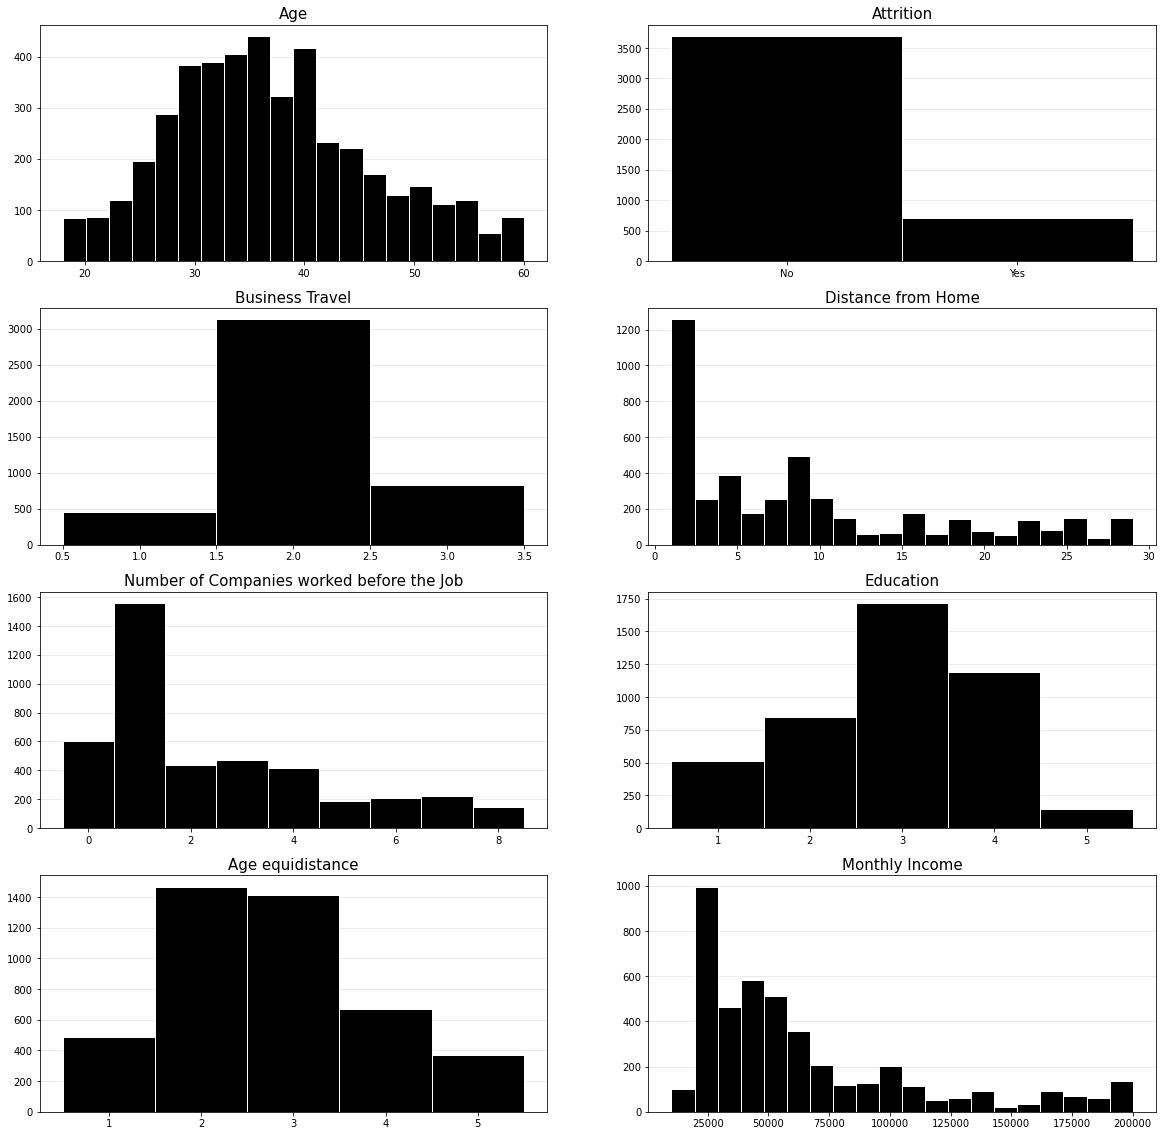

In [71]:
fig = plt.figure(figsize=(20,20))

plt.subplot(4,2,1)
plt.hist(data_dummy['Age'], bins = 20, color = 'black', zorder = 3, edgecolor = 'white')
plt.title('Age', size = 15)
plt.grid(True, axis = 'y', zorder = 0, alpha = 0.3)

plt.subplot(4,2,2)
plt.hist(data_dummy['Attrition'], bins = np.arange(3)-0.5, color = 'black', zorder = 3, edgecolor = 'white')
plt.title('Attrition', zorder = 0, size = 15)
plt.grid(True, axis = 'y', zorder = 0, alpha = 0.3)

plt.subplot(4,2,3)
plt.hist(data_dummy['BusinessTravel'], bins = np.arange(4)+0.5, color = 'black', zorder = 3, edgecolor = 'white')
plt.title('Business Travel', zorder = 0, size = 15)
plt.grid(True, axis = 'y', zorder = 0, alpha = 0.3)

plt.subplot(4,2,4)
plt.hist(data_dummy['DistanceFromHome'], bins = 20, color = 'black', zorder = 3, edgecolor = 'white')
plt.title('Distance from Home', size = 15)
plt.grid(True, axis = 'y', zorder = 0)
plt.grid(True, axis = 'y', zorder = 0, alpha = 0.3)

plt.subplot(4,2,5)
plt.hist(data_dummy['NumCompaniesWorked'],bins = np.arange(10)-0.5,  color = 'black', zorder = 3, edgecolor = 'white')
plt.title('Number of Companies worked before the Job', size = 15)
plt.grid(True, axis = 'y', zorder = 0)
plt.grid(True, axis = 'y', zorder = 0, alpha = 0.3)

plt.subplot(4,2,6)
plt.hist(data_dummy['Education'], bins = np.arange(6)+0.5, color = 'black', zorder = 3, edgecolor = 'white')
plt.title('Education', size = 15)
plt.grid(True, axis = 'y', zorder = 0)
plt.grid(True, axis = 'y', zorder = 0, alpha = 0.3)

plt.subplot(4,2,7)
plt.hist(data_dummy['Age_eqdist'], bins = np.arange(6)+0.5, color = 'black', zorder = 3, edgecolor = 'white')
plt.title('Age equidistance', size = 15)
plt.grid(True, axis = 'y', zorder = 0)
plt.grid(True, axis = 'y', zorder = 0, alpha = 0.3)

plt.subplot(4,2,8)
plt.hist(data_dummy['MonthlyIncome'], bins = 20, color = 'black', zorder = 3, edgecolor = 'white')
plt.title('Monthly Income', zorder = 0, size = 15)
plt.grid(True, axis = 'y', zorder = 0, alpha = 0.3)

plt.show()

##### Zmena v stĺpci cieľovej premennej z Yes/No na True/False

In [72]:
data_dummy['Attrition'] = data_dummy['Attrition'].map({'Yes': True, 'No': False})
data_dummy.head()
#Přiřazení hodnot Yes a No hodnoty True a False, nutné pro potřeby logistické regrese a její analýzy

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Age_eqdist
0,51,False,2,2,6,2,2,2,1,2,131160,1.0,11,0,1.0,6,1,0,0,4
1,31,True,3,3,10,1,2,2,1,3,41890,0.0,23,1,6.0,3,5,1,4,2
2,32,False,3,3,17,4,3,1,4,2,193280,1.0,15,3,5.0,2,5,0,3,2
3,38,False,1,3,2,5,2,1,3,2,83210,3.0,11,3,13.0,5,8,7,5,3
4,32,False,2,3,10,1,1,1,1,3,23420,4.0,12,2,9.0,2,6,0,4,2


### Modelovanie

##### Rozdělení dat na testovací a trénovací v poměru 80/20

In [73]:
#Abychom dostávali pořád stejné hodnoty, použijeme funkci seed
SEED=1

#Poměr rozložení test a train
train_ratio = 0.8
test_ratio = 0.2



#Rozdělení dat na test a train
X_train, X_test, y_train, y_test = train_test_split(
    data_dummy.drop(['Attrition'], axis = 1), # Vysvětlující proměná
    data_dummy[['Attrition']], # Vysvětlovaná proměná
    test_size = test_ratio, #Velikost
    random_state = SEED
    )

#Zobrazení testovacího a trénovacího datasetu
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3528, 19)
(882, 19)
(3528, 1)
(882, 1)


In [74]:
#Náhled na rozložení True/False dat v trénovacích a testovacích datech
print(y_train.value_counts())
print(y_test.value_counts())

Attrition
False        2979
True          549
dtype: int64
Attrition
False        720
True         162
dtype: int64


##### Tvorba modelu LOGIT

In [75]:
#Tvorba modelu Logit - Vytvoření pipeline pro Logistickou regresy
    pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=SEED, penalty='l1', solver='liblinear',max_iter=1000))
#
# Vytvoření gridu parametrů
#
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
#
# Vytvoření estimátoru pro Gridsearch a Crossvalidaci
#
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring='accuracy',
                     cv=5,
                     refit=True,
                     n_jobs=1)
#
# Trénování Logistické regrese
#
gsLR = gsLR.fit(X_train, y_train)
#
# Training score nejlepšího modelu
#
print(gsLR.best_score_)
#
# Parametry nejlepšího modelu
#
print(gsLR.best_params_)
#
# Testové score nejlepšího modelu
#
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8551600265204027
{'logisticregression__C': 10.0}
Test accuracy: 0.828


C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### Graf matice záměn

C:\Users\fstarek\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 1080x1080 with 0 Axes>

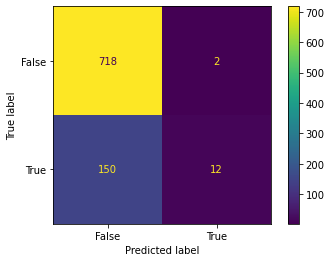

In [76]:
fig = plt.figure(figsize=(15,15))
plot_confusion_matrix(gsLR, X_test,y_test)  
y_pred_log = clfLR.predict(X_test)
plt.show()
#Matice záměn nám ukazuje, kolikrát došlo ke shodě skutečné a předpovězené hodnoty = Jak dobře model dokáže předpovídat

In [77]:
cnf_log=confusion_matrix(y_test,y_pred_log)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_log)) # ((TP+TN)/total) 
print("Precision:",metrics.precision_score(y_test, y_pred_log)) # (TP/(TP + FP)) 
print("Recall:",metrics.recall_score(y_test, y_pred_log)) # (TP/(TP + FN)) 
print("False Negative Rate:",cnf_log[1,0]/cnf_log.sum()) # (TP/(TP + FN))

Accuracy: 0.8276643990929705
Precision: 0.8571428571428571
Recall: 0.07407407407407407
False Negative Rate: 0.17006802721088435


##### Křivka ROC

In [78]:
y_proba_log = gsLR.predict_proba(X_test)[::,1]
fpr_log, tpr_log, threshold_log = metrics.roc_curve(y_test, y_proba_log)

auc = metrics.roc_auc_score(y_test, y_proba_log)
#Tvorba parametrů pro křivku ROC

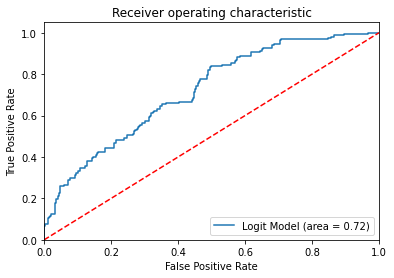

In [45]:
from sklearn.metrics import *
logit_roc_auc = roc_auc_score(y_test, y_proba_log)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_log)
plt.figure()
plt.plot(fpr, tpr, label='Logit Model (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Logit_ROC')
plt.show()
#Graf ROC popisuje kvalitu binárního klasifikátoru v závislosti na nastavení jeho klasifikačního prahu

##### Tvorba modelu PROBIT

In [326]:
#Rozdělení dat na test a train
X_train, X_test, y_train, y_test = train_test_split(
    data_dummy.drop(['Attrition'], axis = 1), # Vysvětlující proměná
    data_dummy[['Attrition']], # Vysvětlovaná proměná
    test_size = test_ratio, #Velikost
    random_state = SEED
    )

#Zobrazení testovacího a trénovacího datasetu
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3528, 17)
(882, 17)
(3528, 1)
(882, 1)


In [327]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc('font', size=14)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)

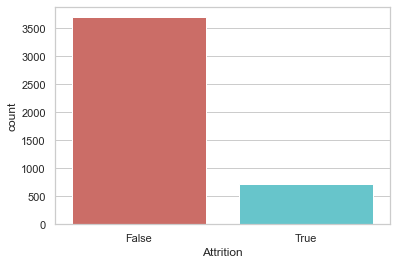

<Figure size 432x288 with 0 Axes>

In [328]:
sns.countplot(x='Attrition', data=data_dummy, palette='hls')
plt.show()
plt.savefig('count_plot')

In [329]:
pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
Note: you may need to restart the kernel to use updated packages.


##### Over-sampling using SMOTE
With our training data created, I’ll up-sample the default class using the SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE:

1. Works by creating synthetic samples from the minor class (default) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [330]:
X = data_dummy.loc[:, data_dummy.columns != 'Attrition']
y = data_dummy.loc[:, data_dummy.columns == 'Attrition']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
columns = X_train.columns
os_data_X,os_data_y = os.fit_resample(X_train, y_train)

AttributeError: module 'sklearn.metrics._dist_metrics' has no attribute 'DatasetsPair'

In [ ]:
cols = ['Age','BusinessTravel','DistanceFromHome','Education','EmployeeID','JobLevel','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager','Age_eqdist']
X = os_data_X[cols]
y = os_data_y['Attrition']

##### Implementing the model

In [ ]:
import statsmodels.api as smf
probit_model = smf.Probit(y,X)
result = probit_model.fit()
print(result.summary2())

##### Probit Model Fitting

In [ ]:
probit=smf.Probit(y_train,X_train)
probit.fit()
print(probit.fit().summary())

##### Extracting the model parameters

In [ ]:
params = pd.DataFrame(probit.fit().params,columns={'coef'},)
params

##### Predicting using the test set

In [ ]:
result1 = X_test
result1['y_pred'] = result1['Age'] * params['coef'][0] + result1['BusinessTravel'] * params['coef'][1] + result1['DistanceFromHome'] * params['coef'][2] + result1['Education'] * params['coef'][3] + result1['EmployeeID'] * params['coef'][4]
result1

##### Applying the Probit function

In [ ]:
import scipy.stats as si
def normsdist(z):
    z = si.norm.cdf(z,0.0,1.0)
    return (z)
normsdist(1.645)

In [ ]:
result1['y_pred_Probit'] = normsdist(result1['y_pred'])
result1

##### Predicting the test set results

In [331]:
d = {'y_pred_proba': result1['y_pred_Probit']}
df23 = pd.DataFrame(data=d)
df23 = df23.reset_index()
df23.drop(['index'], axis=1, inplace=True)
df23['y_pred'] = 0.000
for i in range(0,len(df23['y_pred_proba'])):
    if df23['y_pred_proba'][i] > 0.500:
        df23['y_pred'][i] = 1.000
    else: 
        df23['y_pred'][i] = 0.000
y_pred = np.array(df23['y_pred'])
y_pred = y_pred.astype('int64')
y_pred

NameError: name 'result1' is not defined

##### Calculating the test set accuracy

In [332]:
from sklearn.metrics import accuracy_score
print('Accuracy of Probit Model on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))

NameError: name 'y_pred' is not defined

##### Confusion Matrix


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

##### Estimating the firms’ Attrition probabilities

In [ ]:
y_pred_proba = np.array(df23['y_pred_proba'])
y_pred_proba

##### ROC Curve

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
probit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Probit Model (area = %0.2f)' % probit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Probit_ROC')
plt.show()

NameError: name 'y_pred' is not defined